The Mandelbrot set is the set of all $c$ for which the iteration $z → z^2 + c$, starting from $z = 0$, does not diverge to infinity. Julia sets are either connected (one piece) or a dust of infinitely many points. The Mandelbrot set is those $c$ for which the Julia set is connected.

In [17]:
#Allow cython files to be compiled on Jupyter Notebook
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [18]:
import os

os.environ["CC"] = "gcc"

In [31]:
%%cython -a --compile-args=-O3 --compile-args=-ffast-math --compile-args=-march=native --compile-args=-fopenmp --link-args=-fopenmp

# cython: language_level=3, boundscheck=False, wraparound=False, cdivision=True

from cython.parallel import prange
import numpy as np
cimport numpy as np
cimport cython
import matplotlib.pyplot as plt
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
cimport openmp


    
cdef double complex I = 1j

DEF BAILOUT_RADIUS = 2.0
DEF MAX_ITERS = 20
DEF X_MAX = 2.0
DEF X_MIN = -2.0
DEF Y_MAX = 2.0
DEF Y_MIN = -2.0
DEF WIDTH = 5000
DEF HEIGHT = 5000

cdef inline double complex c_complexify(double real, double imag) nogil:
    return real + imag * I

cdef inline double trans_x(int x) nogil:
    return (x / (WIDTH / (X_MAX - X_MIN))) + X_MIN

cdef inline double trans_y(int y) nogil:
    return (y / (HEIGHT / (Y_MAX - Y_MIN))) + Y_MIN

cdef int escape(double complex z_0, double complex c) nogil:
    cdef int i = 0
    cdef double complex z_n = z_0
    cdef double abs_z_n
    while i < MAX_ITERS:
        abs_z_n = abs(z_n)
        if abs_z_n * abs_z_n >= BAILOUT_RADIUS * 2.0:
            break
        z_n = z_n*z_n + c
        i += 1
    return i

cdef int c_red(int n_iters) nogil:
    return 255 - n_iters

cdef void draw_matplolib(np.int8_t[:, :] img):
    img = np.rot90(img)
    plt.figure(dpi=2000)
    plt.imshow(img, cmap="plasma")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.savefig('mandelbrot.png')

cdef void fill_img(np.int8_t[:, :] img, double complex c) nogil:
    cdef int x
    cdef int y
    cdef int n_iters
    for x in prange(WIDTH, nogil=True):
        for y in range(HEIGHT):
            n_iters = escape(0, c_complexify(trans_x(x), trans_y(y)))
            img[x][y] = c_red(n_iters)

cpdef void draw(double complex c):
    cdef np.int8_t[:, :] img = np.full((WIDTH, HEIGHT), 255, dtype=np.int8)
    fill_img(img, c)
    draw_matplolib(img)

In file included from /usr/local/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /Users/erastusmurungi/.ipython/cython/_cython_magic_651bd12284ffb76493424b6456989d08.c:741:
/usr/local/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
ld: warning: dylib (/usr/local/Cellar/gcc/11.3.0_1/lib/gcc/11/libgomp.dylib) was built for newer macOS version (11.5) than being linked (11.0)


17.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


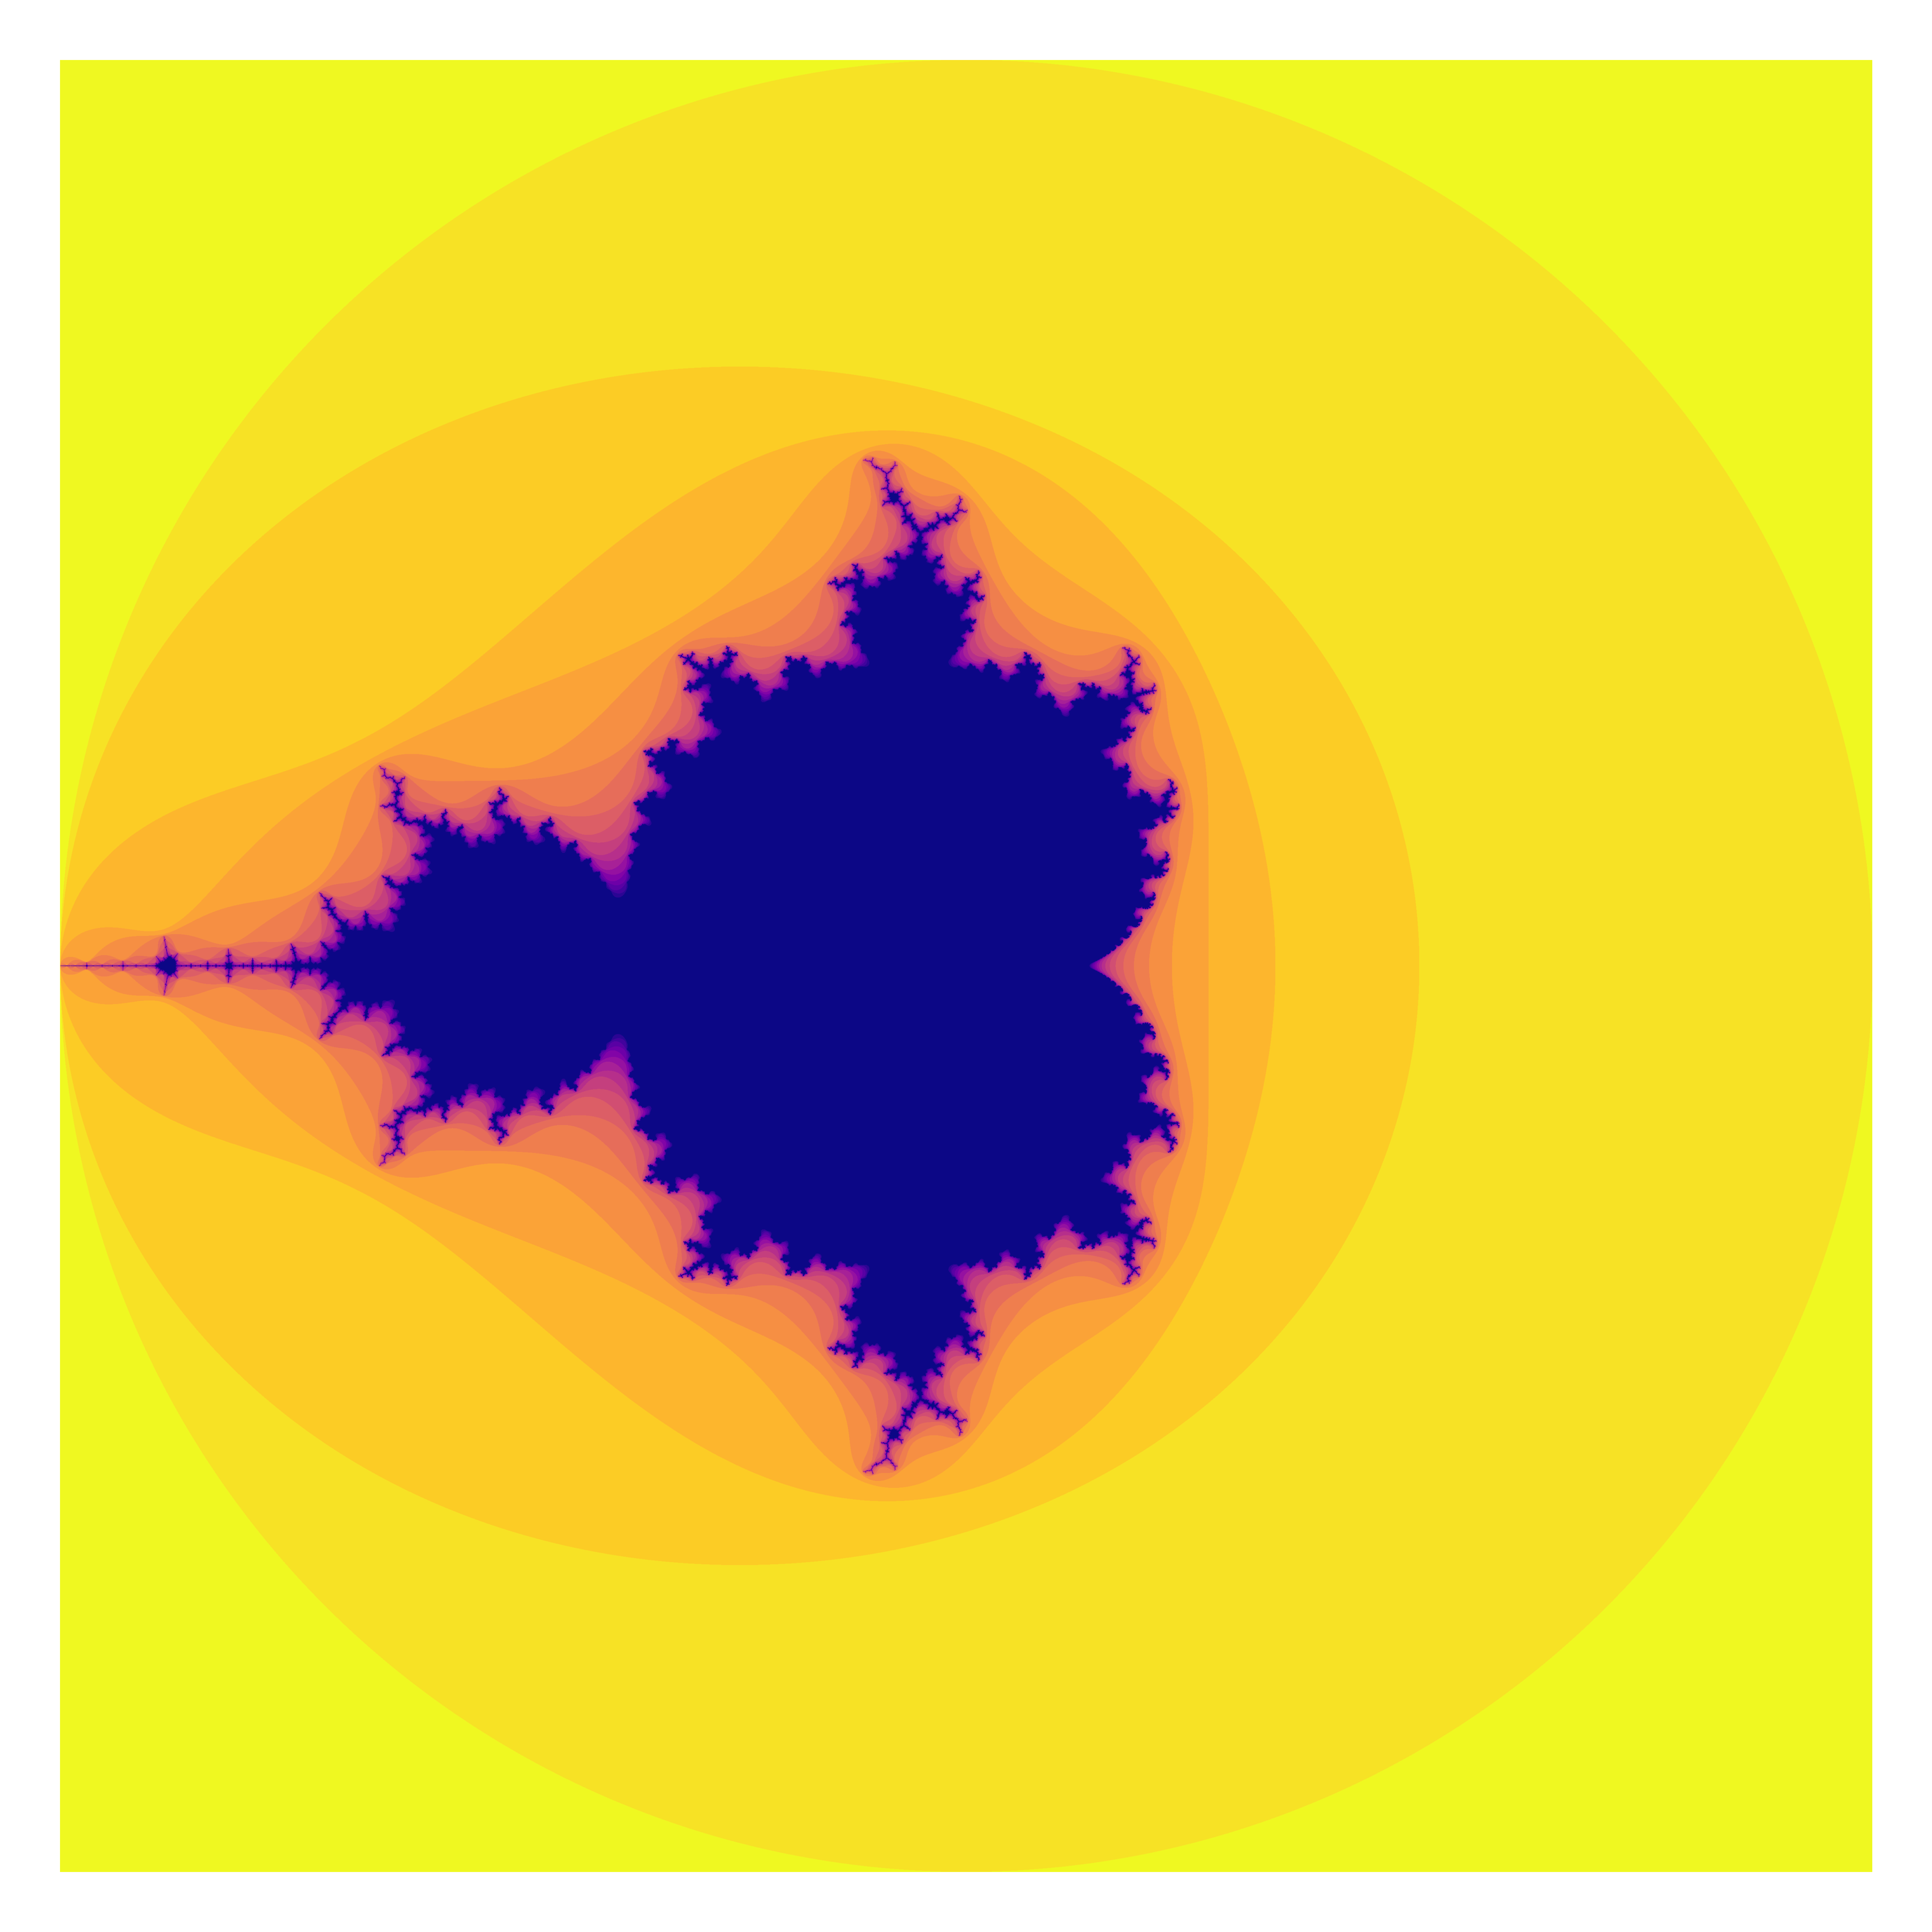

In [32]:
%timeit -r 1 -n 1 draw(complex(-.8, 1.1))

In [14]:
?cython

Docstring:
::

  %cython [-a] [-+] [-3] [-2] [-f] [-c COMPILE_ARGS]
              [--link-args LINK_ARGS] [-l LIB] [-n NAME] [-L dir] [-I INCLUDE]
              [-S SRC] [--pgo] [--verbose]

Compile and import everything from a Cython code cell.

The contents of the cell are written to a `.pyx` file in the
directory `IPYTHONDIR/cython` using a filename with the hash of the
code. This file is then cythonized and compiled. The resulting module
is imported and all of its symbols are injected into the user's
namespace. The usage is similar to that of `%%cython_pyximport` but
you don't have to pass a module name::

    %%cython
    def f(x):
        return 2.0*x

To compile OpenMP codes, pass the required  `--compile-args`
and `--link-args`.  For example with gcc::

    %%cython --compile-args=-fopenmp --link-args=-fopenmp
    ...

To enable profile guided optimisation, pass the ``--pgo`` option.
Note that the cell itself needs to take care of establishing a suitable
profile when executed. 